## Importing Packages

In [1]:
from datasets import load_dataset
from transformers import YolosFeatureExtractor
import json
from pathlib import Path
import numpy as np
import os
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor
import albumentations
import numpy as np
import torch
from transformers import AutoModelForObjectDetection
from transformers import TrainingArguments
from transformers import Trainer
import torchvision
import evaluate
from tqdm import tqdm

## Inputs

In [2]:
#Please change the following to the correct direcotories (Image Dataset) [include entire path]
result_path = r'D:\Python Projects\MMAI\MMAI 5500\Assignment2\result.json' #Path to read results file
meta_path = r'D:\Python Projects\MMAI\MMAI 5500\Assignment2\Labelled Data\images\metadata.jsonl'#Path to write metadata file
# Please ensure meta_path is the same as the folder containing the labelled images, or paste it into that folder

In [3]:
#Please change the following to the correct direcotories (Modelling) [include entire path]
image_path = r"D:\Python Projects\MMAI\MMAI 5500\Assignment2\Labelled Data\images" #Path with Labelled Dataset and Metadata file
model_path = r"D:\Python Projects\MMAI\MMAI 5500\Assignment2\candy_detector" #Path to save new model/load old model
checkpoint_path = r"D:\Python Projects\MMAI\MMAI 5500\Assignment2\candy_detector_checkpoint" #Path to save model checkpoints
counter_image_path = r"D:\Python Projects\MMAI\MMAI 5500\Assignment2\images\cd_04.jpg" #Path to open image to run candy counter
draw_image_path = r"D:\Python Projects\MMAI\MMAI 5500\Assignment2\images\cd_04.jpg" #Path to open image to draw boundaries
eval_path = r"D:\Python Projects\MMAI\MMAI 5500\Assignment2\Eval" #Path to store images for evaluation purpose

## Creating Image Dataset

In [4]:
with open(Path(result_path)) as f:
    cocodata = json.load(f)

In [5]:
# Store Huggingface formated data in a list
huggingdata = []
# Iterate through the images
for image in cocodata['images']:
    img = {'width': [],'height': [],'file_name': [], 'image_id': [], 'objects': []}
    img['width'] = image['width']
    img['height'] = image['height']
    # Remove the image directory from the file name
    img['file_name'] = image['file_name'].split('\\')[-1]
    img['image_id'] = image['id']
    # Extend the image dict with bounding boxes and class labels
    img['objects'] = {'bbox': [], 'category': [], 'area': [], 'id': []}
    # Iterate through the annotations (bounding boxes and labels)
    for annot in cocodata['annotations']:
        # Check if the annotation matches the image
        if annot['image_id'] == img['image_id']:
            # Add the annotation
            img['objects']['bbox'].append(annot['bbox'])
            img['objects']['category'].append(annot['category_id'])
            img['objects']['area'].append(annot['area'])
            img['objects']['id'].append(annot['id'])
        # Append the image dict with annotations to the list
        huggingdata.append(img)

In [6]:
with open(Path(meta_path), 'w+') as f:
    for item in huggingdata:
        f.write(json.dumps(item) + "\n")

## Preprocessing

In [7]:
candy_data = load_dataset('imagefolder', data_dir=Path(image_path))

Found cached dataset imagefolder (C:/Users/hamza/.cache/huggingface/datasets/imagefolder/default-ea5ccece5025ec73/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
categories = {
'Unicorn_whole': 0,
'Black_star': 1,
'Cat': 2,
'Grey_star': 3,
'Insect': 4,
'Moon': 5,
'Owl': 6,
'Unicorn_head': 7
}

label2id = categories
id2label = {v: k for k, v in label2id.items()}

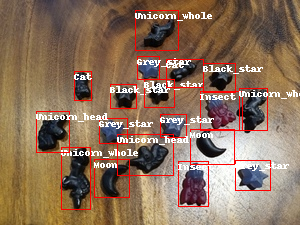

In [9]:
#Visualize the boxes 

image = candy_data["train"][1]["image"]
annotations = candy_data["train"][1]["objects"]
draw = ImageDraw.Draw(image)


for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [10]:
# Removing Images that are incompatible
remove_idx = [2,8] #Boxes out of bounds
keep = [i for i in range(len(candy_data["train"])) if i not in remove_idx]
candy_data["train"] = candy_data["train"].select(keep)

In [11]:
#Using Yolo, ignore warning
checkpoint = "hustvl/yolos-tiny"
image_processor = YolosFeatureExtractor.from_pretrained(checkpoint)

C:\Users\hamza\anaconda3\lib\site-packages\transformers\models\yolos\feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [12]:
#Performing Albumenations
transform = albumentations.Compose(
    [  
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(p=0.2),
    ],
    bbox_params=albumentations.BboxParams(format="coco",label_fields=["category"]),
)

In [13]:
#Creating Proper Format
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [14]:
# Transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [15]:
#Transoforming the Data
eval_data = candy_data["train"].with_transform(transform_aug_ann) #Evaluation Set
candy_data["train"] = candy_data["train"].with_transform(transform_aug_ann) #Training Set

In [16]:
#Performing Collate
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["labels"] = labels
    return batch

## Training the model

In [17]:
#Following is ignored using previous model (see comments two cells down)
#Ignore Warning
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([9, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
training_args = TrainingArguments(
    output_dir=Path(checkpoint_path),
    overwrite_output_dir = True,
    per_device_train_batch_size=4,
    num_train_epochs=100,
    fp16=True,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    evaluation_strategy = "steps",
    save_steps = 50,
    save_strategy = "steps",
    load_best_model_at_end = True
)

In [19]:
# Note, the actual model was trained many times using different albumenation combinations
# model was set to: 
# model = AutoModelForObjectDetection.from_pretrained(Path(model_path))
# Uncomment above and below to train the model again using the previous save as a starting point
# Uncomment only below to train and save the model again from scratch, currently old model is being used


# trainer = Trainer(
#     model=model,
#     args=training_args,
#     data_collator=collate_fn,
#     train_dataset=candy_data["train"],
#     eval_dataset = eval_data,
#     tokenizer=image_processor,
# )

# trainer.train()
# trainer.save_model(Path(model_path))

## Evaluation

In [20]:
candy_data = load_dataset('imagefolder', data_dir=Path(image_path))

Found cached dataset imagefolder (C:/Users/hamza/.cache/huggingface/datasets/imagefolder/default-ea5ccece5025ec73/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations



# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_candy_annotation_file_images(candy):
    output_json = {}
    path_output_candy = Path(eval_path)

    if not os.path.exists(path_output_candy):
        os.makedirs(path_output_candy)

    path_anno = os.path.join(path_output_candy, "candy_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in candy:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w+") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(candy["image"],candy["image_id"]):
        path_img = os.path.join(path_output_candy, f"{img_id}.png")
        im.save(path_img)

    return path_output_candy, path_anno

In [22]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to YOLO format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained(model_path)

path_output_candy, path_anno = save_candy_annotation_file_images(candy_data["train"])
test_ds_coco_format = CocoDetection(path_output_candy, im_processor, path_anno)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [23]:
model = AutoModelForObjectDetection.from_pretrained(model_path)
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

100%|██████████| 2/2 [00:05<00:00,  2.85s/it]

Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.817
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.680
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.633
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.682
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.697
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.689
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

## Candy Counter

In [24]:
image_count = Image.open(Path(counter_image_path))

In [25]:
def candy_counter(image):
    image_processor = AutoImageProcessor.from_pretrained(model_path) #Using Finetuned model
    model = AutoModelForObjectDetection.from_pretrained(model_path) #Using Finetuned model

    with torch.no_grad():
        inputs = image_processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        target_sizes = torch.tensor([image.size[::-1]])
        results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]
        
    count = [0]*len(categories)
    for label in results["labels"]:
        count[label] = count[label] + 1
    
    candy_count = {}
    for value, key in enumerate(categories):
        candy_count[key] = count[value]
        
    return candy_count

In [26]:
candy_counter(image_count)

{'Unicorn_whole': 4,
 'Black_star': 4,
 'Cat': 2,
 'Grey_star': 1,
 'Insect': 3,
 'Moon': 2,
 'Owl': 0,
 'Unicorn_head': 2}

## Draw Image

In [27]:
image_draw = Image.open(Path(draw_image_path))

In [28]:
image_processor = AutoImageProcessor.from_pretrained(model_path)
model = AutoModelForObjectDetection.from_pretrained(model_path)

with torch.no_grad():
    inputs = image_processor(images=image_draw, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image_draw.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Cat with confidence 0.994 at location [163.62, 59.06, 202.83, 87.12]
Detected Grey_star with confidence 0.912 at location [135.43, 57.71, 164.05, 81.49]
Detected Moon with confidence 1.0 at location [94.45, 161.64, 131.84, 197.18]
Detected Unicorn_head with confidence 1.0 at location [33.92, 112.15, 71.4, 153.59]
Detected Unicorn_whole with confidence 1.0 at location [61.47, 148.37, 96.24, 208.74]
Detected Insect with confidence 0.955 at location [199.1, 93.51, 240.78, 130.51]
Detected Unicorn_whole with confidence 0.997 at location [56.08, 137.19, 91.58, 206.44]
Detected Black_star with confidence 0.998 at location [110.41, 83.31, 139.43, 109.12]
Detected Insect with confidence 0.893 at location [175.04, 163.75, 206.89, 206.12]
Detected Insect with confidence 0.937 at location [199.39, 93.77, 241.29, 130.46]
Detected Moon with confidence 0.999 at location [189.3, 130.63, 233.45, 164.66]
Detected Black_star with confidence 0.957 at location [154.44, 113.62, 190.03, 141.44]
Det

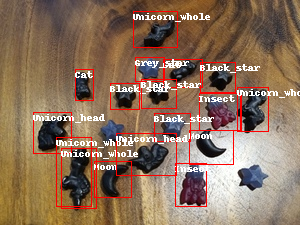

In [29]:
draw = ImageDraw.Draw(image_draw)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image_draw